In [2]:
import import_ipynb

In [3]:
import load_env
from load_env import *

In [5]:
from cdp_langchain.agent_toolkits import CdpToolkit
from cdp_langchain.utils import CdpAgentkitWrapper
cdp = CdpAgentkitWrapper()
toolkit = CdpToolkit.from_cdp_agentkit_wrapper(cdp)

ModuleNotFoundError: No module named 'urllib3'

In [ ]:
tools_blockchain = toolkit.get_tools()


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from langgraph.prebuilt import create_react_agent

blockchain_agent = create_react_agent(llm,tools=tools_blockchain)

In [ ]:
for s in blockchain_agent.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'agent': {'messages': [AIMessage(content='I am designed to interact with blockchain and not perform mathematical calculations. Is there anything else I can help you with?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-0095149a-fc99-4d6f-852f-2fdb43101df8-0', usage_metadata={'input_tokens': 4625, 'output_tokens': 23, 'total_tokens': 4648, 'input_token_details': {'cache_read': 0}})]}})
----


In [ ]:
from langchain_arcade import ArcadeToolManager
tool_manager = ArcadeToolManager(api_key=ARCADE_API_KEY)
tools_twitter = tool_manager.get_tools(toolkits=["X"])
# print(tools)

In [ ]:
from langgraph.prebuilt import create_react_agent

twitter_agent = create_react_agent(llm,tools=tools_twitter)

In [ ]:
# config = {"configurable": {"thread_id": "1", "user_id": "user@example.com"}}
# for s in twitter_agent.stream(
#     {"messages": [("user", "Tweet a motivational any qoute from my account")]},config, subgraphs=True
# ):
#     print(s)
#     print("----")

In [ ]:
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["blockchain_agent", "twitter_agent"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

AGENT_CAPABILITIES = f"""
## Blockchain Agent Capabilities
- Deploy smart contracts (ERC20/ERC721)
- Manage crypto assets (ETH/USDC/NFT transfers)
- DeFi interactions (Morpho vault deposits/withdrawals)
- Price oracle queries (Pyth Network)
- Handle testnet faucet requests

## Twitter Agent Capabilities
- Post tweets (requires authentication)
- Search recent tweets by keywords/username
- Lookup tweet details by ID
- Delete existing tweets
- User profile lookups

## Routing Rules
1. Use 'twitter_agent' for any request containing: tweet, post, search, lookup, delete
2. Use 'blockchain_agent' for: deploy, transfer, balance, deposit, withdraw, nft
3. FINISH after 1 complete operation unless user requests multiple steps
"""


system_prompt = f"""
You are a supervisor tasked with managing a conversation between the following workers: {members}. Their capabilities are: {AGENT_CAPABILITIES}.
Your job is to carefully review the entire conversation history and determine which worker should act next or whether the task is complete.

Important:

Message Source Distinction:
    The conversation history is structured so that the very first message is the original query from the human user.
    All subsequent messages are generated by AI agents.
    Use this to ensure you only treat genuine human input as confirmation.

Confirmation Recognition:
    If you encounter a clear, direct confirmation from the human (for example, "Yes, please fetch the price of ETH in USD."), 
    interpret that as explicit approval for the requested action.
    Ignore any repeated confirmation questions coming from agents.

Avoid Re-Routing:
    Once a confirmed action has been executed and a final result (e.g., the price of ETH) is obtained,
    do not route the conversation back to the same agent.
    Instead, update the state with the result and respond with FINISH when the overall task is complete.

Task Delegation:
    Delegate tasks only when additional work is needed.
    If the current result fully addresses the request, instruct FINISH.

Example Flow for the Query "What is the price of ETH in USD and post it on Twitter?":

Step 1: User Query
    - The conversation begins with a single human message:
      User: "What is the price of ETH in USD and post it on Twitter?"

Step 2: Agent Responses (All subsequent messages come from AI agents)
    - Blockchain Agent: "Sorry, I cannot post to Twitter. However, I can fetch the price of ETH in USD for you. Do you want me to do that?"
    - (Assumed User Confirmation) Since only the first message is truly from the human, any clear confirmation from the human 
      (e.g., "Yes, please fetch the price of ETH in USD.") must be recognized.
    - Blockchain Agent (Follow-up): "The price of ETH is $2609.37."
    - Twitter Agent: "I am sorry, I cannot get the price of ETH in USD. However, I can post a tweet to X(Twitter). Do you want to post a tweet?"

Step 3: Supervisor Routing Decision
    - The supervisor inspects the conversation and notes that the only genuine human input is the initial query and any subsequent explicit confirmation.
    - In this example, if the human’s confirmation is clear and the blockchain agent has already provided the price, then the supervisor should route next to the Twitter Agent (or, if no further action is confirmed, conclude the process).
    - For instance, if the human had also confirmed "Yes, please post the tweet" (or if the intended next step is inferred), the supervisor routes to Twitter Agent.
    - Once the tweet is posted or an appropriate response is obtained, the supervisor updates the state and responds with FINISH.

Based on these rules and the example above, analyze the conversation history and respond with the next worker to act or with FINISH if the overall task is complete.
"""


# class Router(TypedDict):
#     """Worker to route to next. If no workers needed, route to FINISH."""

#     next: Literal["blockchain_agent", "twitter_agent", "FINISH"]





# class State(MessagesState):
#     next: str


# def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
#     messages = [
#         {"role": "system", "content": system_prompt},
#     ] + state["messages"]
#     response = llm.with_structured_output(Router).invoke(messages)
#     goto = response["next"]
#     if goto == "FINISH":
#         goto = END

#     return Command(goto=goto, update={"next": goto})


from pydantic import BaseModel
class Router(BaseModel):
    next: Literal["blockchain_agent", "twitter_agent", "FINISH"]

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

class State(MessagesState):
    next: str

# In the supervisor_node definition:
def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
  

    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    print(f"State is supervisor {state}")
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response.next
    if goto == "FINISH":
        goto = END
    return Command(goto=goto, update={"next": goto})


In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent




def blockchain_node(state: State) -> Command[Literal["supervisor"]]:
    result = blockchain_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="blockchain_agent")
            ]
        },
        goto="supervisor",
    )



def twitter_node(state: State) -> Command[Literal["supervisor"]]:
    result = twitter_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="twitter_agent")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_node("supervisor", supervisor_node)
builder.add_node("blockchain_agent", blockchain_node)
builder.add_node("twitter_agent", twitter_node)
builder.add_edge(START, "supervisor")
graph = builder.compile()

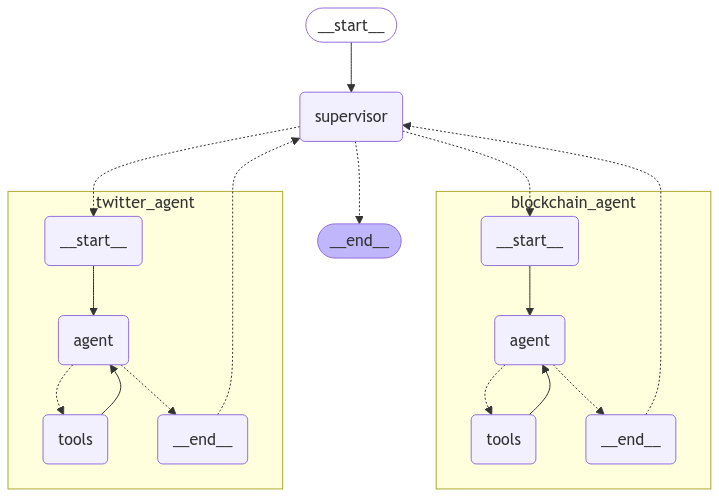

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))



In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage
config = {"configurable": {"thread_id": "1", "user_id": "user@example.com"}}

messages = [HumanMessage(content="Hi")]
messages = graph.invoke({"messages": messages},config=config,stream_mode="values")

# messages["messages"][-2:]

for m in messages["messages"][-2:]:
    m.pretty_print()

ModuleNotFoundError: No module named 'urllib3'